Data is available here https://openi.nlm.nih.gov/faq

download possible from inside accordion box:  ' Where can I get the Chest X-ray images in Open-i ? '

In [ ]:
!pip install -q torchdata
!pip install -q torch_summary

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
from tqdm import tqdm
import re
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!mkdir -p images
!mkdir -p reports
!wget -O images.tgz -q https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
!tar -xf images.tgz -C /content/images/   # !cp -r /content/*.png   /content/images/
!rm images.tgz

!wget -O reports.tgz -q https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz
!tar -xf reports.tgz -C /content/reports/ 
!rm reports.tgz


In [ ]:
image_folder = '/content/images/' #path to folder containing images
total_images = len(os.listdir(image_folder))
reports_folder = '/content/reports/ecgen-radiology/'
total_reports = len(os.listdir(reports_folder))

In [ ]:
#@title xml to dataframe { form-width: "20%" }

# R E F E R E N C E for this section of code : https://ashishthomaschempolil.medium.com/ 
no_images = [] 
for file in os.listdir(reports_folder):
  report_file = os.path.join(reports_folder,file)
  with open(report_file, 'r') as f: 
    data = f.read()
  regex = r"parentImage id.*" 
  k  = re.findall(regex,data)
  temp = len(k)
  no_images.append(temp)

no_images = np.array(no_images)

def decontracted(phrase): 
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_info(xml_data,info): 
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

def get_final(data):
  """
  given an xml data returns "COMPARISON","INDICATION","FINDINGS","IMPRESSION" part of the data
  """
  try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
  except:
    comparison = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    indication = get_info(data, "INDICATION")
  except:
    indication = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    finding = get_info(data,"FINDINGS")
  except:
    finding = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    impression = get_info(data, "IMPRESSION")
  except:
    impression = np.nan;

  return comparison,indication,finding,impression

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(reports_folder)):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: 
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]

      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
      im1.append(image1)
      im2.append(image2)

      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name

    
    elif len(k)<2:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan


      im1.append(image1)
      im2.append(image2)
      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name
    
    else: #if there are more than 2 images concerned with report
      comparison,indication,finding,impression = get_final(data)

      for i in range(len(k)-1):
        regex = r"\".*\"" #getting the name
        image1 = re.findall(regex,k[i])[0] #re.findall returns a list
        image2 = re.findall(regex,k[i+1])[0] 

        image1 = re.sub(r"\"","",image1) #removing "
        image2 = re.sub(r"\"","",image2) #removing "

        image1 = image1.strip()+".png"
        image2 = image2.strip()+".png"

        im1.append(image1)
        im2.append(image2)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file) #xml file name
    
  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df

df = get_df()

In [ ]:
df.to_pickle("/content/df.pkl")
df = pd.read_pickle("/content/df.pkl")
df.shape

(4169, 7)

In [ ]:
#@title dataframe modifications { form-width: "20%" }

df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()

df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index, _ in df.iterrows(): #index, row --> row.get('image_2')
  # if cv2.imread(os.path.join(image_folder,str(df.loc[index,'image_1']))) is not None\
  # and cv2.imread(os.path.join(image_folder,str(df.loc[index,'image_2']))) is not None:
    im1_size.append( cv2.imread(os.path.join(image_folder, str(df.loc[index,'image_1']))).shape[:2])
    im2_size.append(cv2.imread(os.path.join(image_folder, str(df.loc[index,'image_2']))).shape[:2])

#df = df[:len(im1_size)]
df['im1_height'] = [i[0] for i in im1_size]
df['im1_width'] = [i[1] for i in im1_size]
df['im2_height'] = [i[0] for i in im2_size]
df['im2_width'] = [i[1] for i in im2_size]

CPU times: user 39.7 s, sys: 1.35 s, total: 41 s
Wall time: 43.2 s


In [ ]:
df.to_pickle("/content/df_final.pkl")
df = pd.read_pickle("/content/df_final.pkl")
df.shape

(4033, 11)

In [ ]:
train, test = train_test_split(df, test_size = 0.1, random_state = 420)
test = test.reset_index(drop=True)
train = train.reset_index(drop=True)

In [ ]:
tokenizer = get_tokenizer('basic_english')
train_iter = train['impression'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in train_iter]
all_tokens = [w for sublist in all_tokens for w in sublist]

def yield_tokens(data_iter):
    for text in all_tokens:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(all_tokens), specials=["<unk>"], special_first=True)

vocab.set_default_index(vocab["<unk>"])

vocab(['<start>', 'here', 'is', 'an', 'example', '<end>'])

[0, 1176, 18, 194, 0, 0]

In [ ]:
class CaptioningData(Dataset):
    def __init__(self, root, df, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab
        self.transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))]
        )
    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        row = self.df.iloc[index].squeeze()
        id = row.image_1
        image_path = f'{self.root}/{id}'
        image = Image.open(os.path.join(image_path)).convert('RGB')

        caption = row.impression
        tokens = str(caption).lower().split()
        target = []
        target.append(vocab['<start>'])
        target.extend([vocab[token] for token in tokens])
        target.append(vocab['<end>'])
        target = torch.Tensor(target).long()
        return image, target, caption
    def choose(self):
        return self[np.random.randint(len(self))]
    def __len__(self):
        return len(self.df)
    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end] 
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)

trn_ds = CaptioningData('images', train, vocab)
val_ds = CaptioningData('images', test, vocab)

image, target, caption = trn_ds.choose()
plt.imshow(image); print(target)

In [ ]:
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1] # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
encoder = EncoderCNN(256).to(device)

print(summary(encoder,torch.zeros(32,3,224,224).to(device)))

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True) 
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1) # sampled_ids: (batch_size, max_seq_length)
        # convert predicted tokens to strings
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []
            for word_id in sampled_id:
                word = vocab.lookup_token(word_id) #vocab[word_id] but we want to convert tokenid back to token vocab.lookup_token(word_id) 
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
        return sentences

In [ ]:
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss

In [ ]:
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab), 1).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
n_epochs = 1  #try at least 20

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
history = {'train': [], 'valid': [], 'accuracy': []}

for epoch in range(n_epochs):
    if epoch == 5: optimizer = torch.optim.AdamW(params, lr=1e-4)
    trainloss = []
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        trainloss.append(trn_loss)
        print('Epoch {}/{} --- Training Loss: {:.4f}\r'.format(epoch, n_epochs, trn_loss))

    validloss = []
    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        validloss.append(val_loss)
        print('Epoch {}/{} --- Validation Loss: {:.4f}\r'.format(epoch, n_epochs, val_loss))

    history['train'].append(trainloss)
    history['valid'].append(validloss)
    history['accuracy'].append(sum(validloss)/len(validloss))

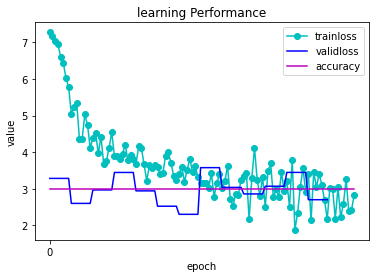

In [ ]:
def plot_scores(history):
  trainlosses  = [i.item() for i in history['train'][0]]
  validlosses = [i.item() for i in history['valid'][0]]
  accuracies = [i.item() for i in history.get('accuracy')]

  trainrainlen = len(trainlosses)
  validlen = len(validlosses)
  acclen = len(accuracies)
  ratioA = trainrainlen//validlen
  ratioB = trainrainlen//acclen

  val = np.repeat(validlosses, ratioA).tolist()
  acc = np.repeat(accuracies, ratioB).tolist()

  plt.plot(trainlosses, '-co')
  plt.plot(val, '-b')
  plt.plot(acc, '-m')

  plt.xticks(range(n_epochs))
  plt.legend(['trainloss', 'validloss', 'accuracy'])
  plt.xlabel('epoch')
  plt.ylabel('value')
  plt.title('learning Performance');

plot_scores(history)

no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no acute cardiopulmonary abnormality . no


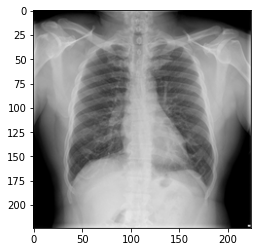

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image

@torch.no_grad()
def load_image_and_predict(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    plt.imshow(org_image)

    sentence = re.sub("<unk> ", "", sentence)
    return print(sentence)

load_image_and_predict(f"{image_folder}{test.loc[17, 'image_1']}")